### Import

In [55]:
import pandas as pd
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
from read import read_datasets, get_subsets
datasets = read_datasets()
list(datasets.keys())

['oversampled_normalized',
 'undersampled_normalized',
 'undersampled',
 'oversampled',
 'normalClass',
 'normalClass_normalized']

### Linear Regression

#### Define functions for running linear regression tests

In [57]:
from sklearn.linear_model import LinearRegression
def run_linearRegression(dataset_name, subset = []):
    assert dataset_name in datasets

    X_train, X_test, y_train, y_test = get_subsets(datasets[dataset_name])
    
    if subset:
        assert any(c in X_train.columns for c in subset)
        X_train = X_train[[c for c in subset if c in X_train.columns]]
        X_test = X_test[[c for c in subset if c in X_test.columns]]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    coefficients = pd.DataFrame({
        "variable":["INTERCEPT"] + list(X_train.columns),
        "coefficient":[model.intercept_] + list(model.coef_)
    })


    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return coefficients, y_test, y_pred, mse, r2

In [66]:
def test_diff_datasets(subset = []):
    results = {
        "dataName":[name for name in datasets],
        "featureSubset":[subset for name in datasets],
        "mse":[],
        "r2":[]
    }
    for name in datasets:
        _, _, _, mse, r2 = run_linearRegression(name, subset)
        results["mse"].append(mse)
        results["r2"].append(r2)
    
    return pd.DataFrame(results).sort_values(by = "r2").reset_index(drop = True)

In [69]:
def getCombos(dataName, drop = []):
    X_train, _, _, _ = get_subsets(datasets[dataName])

    cols = list(X_train.columns)
    if drop:
        cols = [c for c in cols if c not in drop]
    assert cols

    combos = []
    for i in range(1, len(cols) + 1):
        combos.extend(combinations(cols, i))
    
    return combos

#### Test All Feature Subsets

In [63]:
dfOut = pd.DataFrame
for combo in tqdm(getCombos("normalClass"), desc = "Subset Testing"):
    result = test_diff_datasets(combo)
    if dfOut.empty:
        dfOut = result
    else:
        dfOut = pd.concat([dfOut, result])

Subset Testing: 100%|██████████| 2047/2047 [02:19<00:00, 14.71it/s]


In [64]:
bestPerDataName = dfOut.groupby('dataName', as_index=False).apply(lambda x: x.nlargest(1, columns='r2')).reset_index(drop = True)
bestPerDataName

,dataName,featureSubset,mse,r2
0,normalClass,"(fixed acidity, volatile acidity, residual sug...",0.375114,0.340628
1,normalClass_normalized,"(fixed acidity, volatile acidity, residual sug...",0.379095,0.333631
2,oversampled,"(fixed acidity, volatile acidity, citric acid,...",0.948022,0.670136
3,oversampled_normalized,"(fixed acidity, volatile acidity, citric acid,...",0.955661,0.667478
4,undersampled,"(fixed acidity, volatile acidity, residual sug...",0.386782,0.791398
5,undersampled_normalized,"(volatile acidity, residual sugar, free sulfur...",1.310850,0.293025


#### Manually Remove Collinearity

In [72]:
dropCols = ["free sulfur dioxide", "pH", "sulfur", "citric acid", "volatile acidity"]

dfOut_subset = pd.DataFrame
for combo in tqdm(getCombos("normalClass", dropCols), desc = "Subset Testing"):
    result = test_diff_datasets(combo)
    if dfOut_subset.empty:
        dfOut_subset = result
    else:
        dfOut_subset = pd.concat([dfOut_subset, result])

Subset Testing: 100%|██████████| 511/511 [00:35<00:00, 14.60it/s]


In [73]:
bestPerDataName_subset = dfOut_subset.groupby('dataName', as_index=False).apply(lambda x: x.nlargest(1, columns='r2')).reset_index(drop = True)
bestPerDataName_subset

,dataName,featureSubset,mse,r2
0,normalClass,"(fixed acidity, residual sugar, chlorides, tot...",0.400304,0.296351
1,normalClass_normalized,"(fixed acidity, residual sugar, chlorides, tot...",0.407050,0.284492
2,oversampled,"(fixed acidity, residual sugar, chlorides, fre...",1.095498,0.618822
3,oversampled_normalized,"(fixed acidity, residual sugar, chlorides, den...",1.106794,0.614892
4,undersampled,"(fixed acidity, chlorides, free sulfur dioxide...",1.013596,0.453342
5,undersampled_normalized,"(fixed acidity, chlorides, free sulfur dioxide...",1.621071,0.125715


### Read in R Data

In [1]:
library(ISLR)
library(gam)
library(splines)
library(tidyverse)
library(caret)
library(dplyr)
library(nnet)

Warning message:
"package 'gam' was built under R version 4.1.2"
Loading required package: splines

Loading required package: foreach

Warning message:
"package 'foreach' was built under R version 4.1.2"
Loaded gam 1.22-2


Warning message:
"package 'tidyverse' was built under R version 4.1.2"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.1
v tibble  3.2.1     v dplyr   1.1.1
v tidyr   1.2.0     v stringr 1.5.0
v readr   2.1.2     v forcats 0.5.2
Warning message:
"package 'ggplot2' was built under R version 4.1.2"
Warning message:
"package 'tibble' was built under R version 4.1.2"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'purrr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.2"
Warning message:
"package 'stringr' was built under R version 4.1.2"
Warnin

In [2]:
files <- c()
dfs <- list()
for(file in list.files("data/")){
    if(file != "winequality.csv"){
        files <- append(files, strsplit(file, "\\.")[[1]][1])
        dfs <- append(dfs, list(read.csv(paste("data/",file,sep = ""), header = T)))
    }
}

In [3]:
getSplit <- function(df, train_or_test){
    retDf <- subset(df, train_test == train_or_test)
    retDf$train_test <- NULL
    return (retDf)
}

train_dfs <- list()
test_dfs <- list()
for(df in dfs){
    train_dfs <- append(train_dfs, list(getSplit(df, "train")))
    test_dfs <- append(test_dfs, list(getSplit(df, "test")))
}

### GAM

#### Define functions to be used for the model testing

In [5]:
runModel <- function(train, test){
  predictors <- names(train)[!names(train) == "quality"]
  model <- gam(as.formula(paste("quality ~ ",paste("s(", predictors, ")", collapse = "+"))),
               data = train, select = T)
  preds <- model %>% predict(test)
  rmse <- RMSE(preds, test$quality)
  r2 <- R2(preds, test$quality)

  return(c(rmse, r2))
}

runOnAllData <- function(subset_cols){
  resultFiles <- c()
  rmses <- c()
  r2s <- c()
  feats <- c()

  for(i in 1:length(files)){

    rmse_r2 <- runModel(train_dfs[[i]][subset_cols], test_dfs[[i]][subset_cols])
    
    rmse <- rmse_r2[1]
    r2 <- rmse_r2[2]

    resultFiles <- append(resultFiles, files[i])
    rmses <- append(rmses, rmse)
    r2s <- append(r2s, r2)
    feats <- append(feats, paste(subset_cols[-length(subset_cols)], collapse = "_"))
  }
  fullModelResults <- data.frame(name = resultFiles, features = feats,
                                 rmse = rmses, r2 = r2s)
  return(fullModelResults)
}

getCombos <- function(drop_cols = c()){
  allCombos <- list()

  allCols <- names(train_dfs[[1]])
  allCols <- allCols[!allCols %in% drop_cols]
  

  predCols <- allCols[-length(allCols)]

  for(size in 1:length(predCols)){
    combos <- combn(predCols, size)
    for(j in 1:ncol(combos)){
      combo <- list()
      for(i in 1:nrow(combos)){
        combo <- append(combo, combos[i,j])
      }
      allCombos <- append(allCombos, list(combo))
    }
  }
  return(allCombos)
}

drop_cols <- c("free.sulfur.dioxide", "pH", "sulfur", "citric.acid", "volatile.acidity")
combos <- getCombos(drop_cols)

#### Run all subsets of features, to get optimal featuresets.

In [6]:
resultsDf <- NULL
for(i in 1:length(combos)){
    if(is.null(resultsDf)){
        resultsDf <- runOnAllData(c(unlist(combos[[i]]), "quality"))
    }
    else{
        resultsDf <- rbind(resultsDf, runOnAllData(c(unlist(combos[[i]]), "quality")))
    }
}

In [7]:
# arrange(resultsDf, desc(r2))
bestResults <- resultsDf %>% 
  group_by(name) %>%
  top_n(n = 1, wt = r2) %>% 
  arrange(name, desc(r2))
bestResults

name,features,rmse,r2
<chr>,<chr>,<dbl>,<dbl>
normalClass,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6184345,0.3358167
normalClass_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6254710,0.3327850
oversampled,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9901225,0.6610158
oversampled_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9975696,0.6576387
undersampled,chlorides_sulphates_alcohol,0.9415901,0.5233186
undersampled_normalized,fixed.acidity_residual.sugar_sulphates_alcohol,1.2892388,0.7026790


### ANN Pseudo-Regression

In [36]:
fileNames <- c()
hl_sizes <- c()
rmses <- c()
for(i in 1:length(train_dfs)){
    for(hl_size in 1:5){
        model <- nnet(quality ~ ., data = train_dfs[[i]], linout = T, skip = F, size = c(hl_size))
        preds <- predict(model, newdata = test_dfs[[i]], type = "r")
        rmse <- RMSE(preds, test_dfs[[i]]$quality)

        fileNames <- append(fileNames, files[i])
        hl_sizes <- append(hl_sizes, hl_size)
        rmses <- append(rmses, rmse)
    }
}
NN_results <- data.frame(names = fileNames, hiddenLayerSize = hl_sizes, rmse = rmses)
NN_results

# weights:  14
initial  value 39352.085300 
final  value 858.777170 
converged
# weights:  27
initial  value 38647.949128 
final  value 858.777129 
converged
# weights:  40


initial  value 61416.200174 
final  value 858.777170 
converged
# weights:  53
initial  value 47809.919356 
final  value 858.768073 
converged
# weights:  66
initial  value 46031.028885 
iter  10 value 986.047808
final  value 858.777360 
converged
# weights:  14
initial  value 54502.342685 
iter  10 value 638.007959
iter  20 value 582.462516
iter  30 value 577.025443
iter  40 value 572.851265
iter  50 value 554.484897
iter  60 value 537.064905
iter  70 value 535.771941
iter  80 value 535.758930
final  value 535.755273 
converged
# weights:  27
initial  value 33679.716192 
iter  10 value 826.634572
iter  20 value 726.475200
iter  30 value 555.180565
iter  40 value 524.488794
iter  50 value 521.240370
iter  60 value 520.056078
iter  70 value 519.827644
iter  80 value 518.811711
iter  90 value 517.075610
iter 100 value 516.332419
final  value 516.332419 
stopped after 100 iterations
# weights:  40
initial  value 33254.101253 
iter  10 value 690.408698
iter  20 value 559.779967
iter  30 va

names,hiddenLayerSize,rmse
<chr>,<int>,<dbl>
normalClass,1,0.7577175
normalClass,2,0.7577175
normalClass,3,0.7577175
normalClass,4,0.7577277
normalClass,5,0.7577172
normalClass_normalized,1,0.6304984
normalClass_normalized,2,0.6455907
normalClass_normalized,3,0.6650344
normalClass_normalized,4,0.6666962


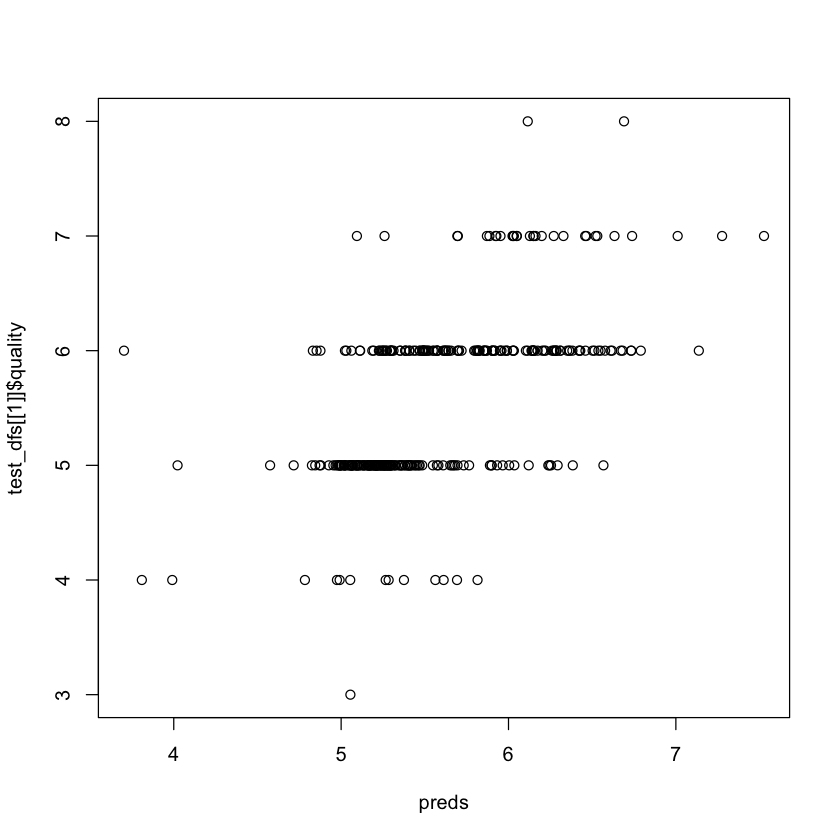

In [31]:
plot(preds, test_dfs[[1]]$quality)